<a href="https://colab.research.google.com/github/AhaTree/Rubbish/blob/master/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os 
os.chdir(r'/content/drive/My Drive/Colab Notebooks')
!mkdir -p Retina/
!wget http://cecas.clemson.edu/~ahoover/stare/images/all-images.zip
!unzip /content/all-images.zip
!mv *.ppm ./Retina

In [0]:
import os
os.chdir(r'/content/drive/My Drive/Colab Notebooks')

In [0]:
from __future__ import print_function
import os
import argparse
import torch
import torch.utils.data
from PIL import Image
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms,utils
from torchvision.utils import save_image
import pandas as pd
from skimage import io,transform
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader

Image_Path=r'/content/drive/My Drive/Colab Notebooks/Face/faces'
Device = torch.device("cuda")
bsz=64 # Batch Size
tsz=64 # taining image 64*64
rsz=64 # result image 128*128

class RetinaData(Dataset):
    def __init__(self): pass
    
    def __len__(self):
        return len(img_names)

    def __getitem__(self,idx):
        return images[idx]


data_transform = transforms.Compose([
        #transforms.CenterCrop(3*128),
        transforms.Resize((64,64)),
        transforms.ToTensor()
    ])
img_names = list(pd.read_csv(os.path.join(Image_Path,'filename.csv'))['filename'])
images = [data_transform(Image.open(os.path.join(Image_Path,img_name))) for img_name in img_names]
rdata=RetinaData()

In [0]:
#'''
def transformer(data): # batch, channel, height, weight
    rsz=128
    bsz=data.shape[0]
    xy1=torch.randint(0,rsz-tsz,(2,bsz))
    xy2=xy1+rsz
    xy=(rsz-tsz)//2
    data1=torch.stack([data[i, :, xy1[0, i]:xy2[0, i], xy1[1, i]:xy2[1, i]] for i in range(bsz)])
    data2=data1[:,:,xy:-xy, xy:-xy]
    #return data2, data1
    return data2,data2
#'''

In [0]:
def transformer(data): return data,data

In [0]:
newLoader = lambda: map(transformer, iter(DataLoader(rdata, batch_size=bsz, shuffle=True)))

In [0]:
def  ShowSample(img):
    total = len(img)
    title=('Input','Target(GT)','Output')
    for i, data in enumerate(img):
        plt.subplot(1, total, i + 1)
        plt.title(title[i])
        plt.imshow(data.permute(1,2,0).cpu().numpy())
        
    plt.show()

In [0]:
ShowSample(next(iter(newLoader()))[0][0:3])

In [0]:
def ConvSz(size,krl,strd,padd=0):
    return (size+2*padd-krl)//strd+1

In [0]:
class FRM(nn.Module):
  '''The feature recalibration module'''
  def __init__(self, channel, reduction=16):
    super(FRM, self).__init__()
    # global average pooling: feature --> point
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    # feature channel downscale and upscale --> channel weight
    self.conv_du = nn.Sequential(
      nn.Conv2d(channel, channel//reduction, 1, padding=0, bias=True),
      nn.ReLU(inplace=True),
      nn.Conv2d(channel//reduction, channel, 1, padding=0, bias=True),
      nn.Sigmoid()
    )

  def forward(self, x):
    y = self.avg_pool(x)
    y = self.conv_du(y)
    return x * y

In [0]:
class LB(nn.Module):
  def __init__(self, inChannels,outChannels):
    super(LB, self).__init__()
    # reshape the channel size
    self.conv_1 = nn.Conv2d(inChannels, inChannels, kernel_size=3, padding=1, bias=False)
    self.conv_2 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding=1, bias=False)
    self.relu = nn.PReLU()
    self.se = FRM(channel=inChannels,reduction=16)
  def forward(self, x):
    out = self.relu(self.conv_1(x))
    out = self.conv_2(out)
    out = self.se(out) + x
    return out

In [0]:
class VAE(nn.Module):
    def __init__(self, size=64):
        super(VAE, self).__init__()
        
        ch=(64,128,256,256)
        krl=(3,3,3,3)
        strd=(1,1,1,2)
        codsz=512
        
        #conv
        self.conv0=nn.Conv2d(3,ch[0],krl[0],strd[0],dilation=2,padding=1)
        self.consz0=ConvSz(size,krl[0],strd[0])
        self.batno0=nn.BatchNorm2d(3)
        
        self.conv1=nn.Conv2d(ch[0],ch[1],krl[1],strd[1],dilation=2,padding=1)
        self.consz1=ConvSz(self.consz0,krl[1],strd[1])
        self.batno1=nn.BatchNorm2d(ch[1])
        
        self.conv2=nn.Conv2d(ch[1],ch[2],krl[2],strd[2])
        self.consz2=ConvSz(self.consz1,krl[2],strd[2])
        self.batno2=nn.BatchNorm2d(ch[2])
        
        self.conv22=nn.Conv2d(ch[2],ch[3],krl[3],strd[3])
        self.consz22=ConvSz(self.consz2,krl[3],strd[3])
        
        #encode
        self.encdsz=ch[3]*(self.consz22**2)
        self.batno3=nn.BatchNorm2d(ch[2])
        self.fc1 = nn.Linear(self.encdsz, codsz)
        self.fc2 = nn.Linear(self.encdsz, codsz)
        
        #decode
        self.fc3 = nn.Linear(codsz, 16*16)
        
        self.conv3=nn.Conv2d(1,3*2*2,3,1,padding=1)
        self.batno4=nn.BatchNorm2d(3*2*2)
        self.pisf1=nn.PixelShuffle(2)
        
        self.conv4=nn.Conv2d(3,3*2*2,3,1,padding=1)
        self.batno5=nn.BatchNorm2d(3*2*2)
        self.pisf2=nn.PixelShuffle(2)
               
        # self.conv5=nn.Conv2d(3,3*2*2,3,1,padding=1)
        # self.pisf3=nn.PixelShuffle(2)
        self.conv5=nn.Conv2d(3,64,1,1)
        self.lb=LB(64,64)
        self.conv6=nn.Conv2d(64,3,1,1)
        self.dropout=nn.Dropout(p=0.5)
        

    def conv(self,x):
        x=F.relu(self.conv0(self.batno0(x)))
        #print(x.shape)
        x=F.relu(self.conv1(x))
        #print(x.shape)
        x=F.relu(self.conv2(x))
        #print(x.shape)
        x=F.relu(self.conv22(x))
        #print(x.shape)
        return x
    
    def encode(self, x):
        #x=self.batno3(x)
        x=x.view(-1,self.encdsz)
        return self.fc1(x), self.fc2(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z=z.view(-1,1,16,16)
        z=self.pisf1(self.conv3(z))
        z=self.pisf2(self.conv4(z))
        z=self.conv5(z)
        z=self.lb(z)
        z=self.conv6(z)
        # z=self.pisf3(self.conv5(z))
        #z=torch.sigmoid(z)
        return z

    def forward(self, x):
        x=x.to(Device)
        x=self. conv(x)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(Device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [0]:
input=torch.rand(1,3,64,64)
model(input)

In [0]:
def lossFn(model, label, out, mu, logvar, *_):
    a=0.8
    b=2
    mse=F.mse_loss(out, label, reduction='sum') 
    # + a*(mu ** 2 - logvar + logvar.exp()).sum()
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    nagimg=torch.mean(label,(2,3),keepdim=True).expand(-1,-1,rsz,rsz).contiguous().view(-1,3*rsz*rsz)
    # print(nagimg.shape)
    poimg=label.contiguous().view(-1,3*rsz*rsz)
    #print(poimg.shape)
    outimg=out.contiguous().view(-1,3*rsz*rsz)
    #print(outimg.shape)
    tmg=F.triplet_margin_loss(outimg,poimg,nagimg)
    return mse+a*KLD+b*tmg

In [0]:
def trainStep(model, x, y):
    optimizer.zero_grad()
    x = x.contiguous().to(Device, non_blocking=True)
    label = y.contiguous().to(Device, dtype=torch.float, non_blocking=True)
    loss = lossFn(model, label, *model(x))
    if torch.allclose(loss, nan, equal_nan=True):
        raise Exception('Loss returns NaN')
    loss.backward()
    nn.utils.clip_grad_value_(model.parameters(), 0.5)
    optimizer.step()
    return float(loss)

In [0]:
predict = lambda x: x

def evaluateStep(model, x, y):
    x = x.contiguous().to(Device, non_blocking=True)
    y = y.contiguous().to(Device, dtype=torch.float, non_blocking=True)
    out, *others = model(x)
    pred = predict(out)
    
    B=8; 
    MAX=2^B-1;
    MES=sum(sum((y-out)**2))/(rsz**2);
    PSNR=20*torch.log10(MAX/torch.sqrt(MES))
    
    #missed = lossFn(model,y, out,*others)
    missed=PSNR
    return (float(missed.sum()), missed, pred, *others)

def evaluate(model,i=0):
    model.eval()
    totalErr = 0
    count = 0
    for x, y in newLoader():
        count += x.shape[0]
        err, _, pred, _, *others = evaluateStep(model, x, y)
        totalErr += err
    if(i%10==0):ShowSample((x[0],y[0],pred.detach()[0]))
    return totalErr / count


In [0]:
nan = torch.tensor(float('nan'), device=Device)
def train(model, init=True):
    valErr = evaluate(model)
    print('valid error: %.3f' % (valErr, ))
    
    for i in range(epoch):
        totalLoss = 0
        model.train()
        model.zero_grad()
        count = 0
        for x, y in newLoader():
            count += x.shape[0]
            loss = trainStep(model, x, y)
            totalLoss += loss
        valErr = evaluate(model,i)
        
        print('Epoch #%i | train loss: %.4f | valid error: %.3f' %
          (i, totalLoss / count, valErr, ))
        # torch.save(model.state_dict(), 'model.epoch{}.pth'.format(i))
    for i in range(10):
      evaluate(model)
    return valErr


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


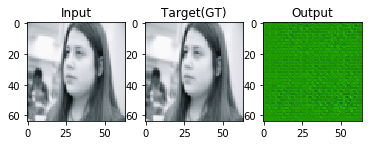

valid error: 4839.405


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


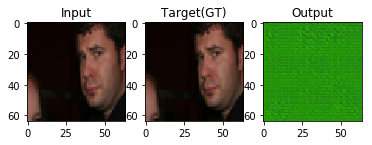

Epoch #0 | train loss: 2098.8015 | valid error: 4956.886
Epoch #1 | train loss: 1920.5832 | valid error: 4945.105
Epoch #2 | train loss: 1744.0237 | valid error: 5029.833
Epoch #3 | train loss: 1576.6437 | valid error: 5075.399
Epoch #4 | train loss: 1420.3367 | valid error: 5056.086
Epoch #5 | train loss: 1277.5722 | valid error: 5123.039
Epoch #6 | train loss: 1157.5359 | valid error: 5172.882
Epoch #7 | train loss: 1072.7012 | valid error: 5168.862
Epoch #8 | train loss: 1033.0397 | valid error: 5180.603
Epoch #9 | train loss: 1049.6702 | valid error: 5172.666


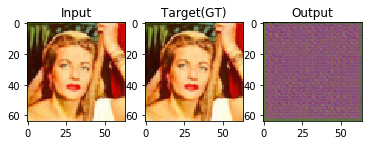

Epoch #10 | train loss: 1084.5909 | valid error: 5111.043
Epoch #11 | train loss: 1104.6870 | valid error: 5132.844
Epoch #12 | train loss: 1100.3630 | valid error: 5195.435
Epoch #13 | train loss: 1078.2801 | valid error: 5201.927
Epoch #14 | train loss: 1051.9034 | valid error: 5237.697
Epoch #15 | train loss: 1034.4951 | valid error: 5129.567
Epoch #16 | train loss: 1033.0728 | valid error: 5196.587
Epoch #17 | train loss: 1039.8932 | valid error: 5141.746
Epoch #18 | train loss: 1043.1660 | valid error: 5258.823
Epoch #19 | train loss: 1038.6282 | valid error: 5196.558


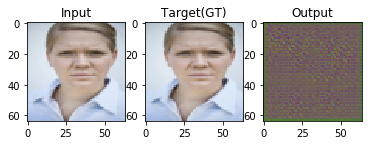

Epoch #20 | train loss: 1030.3081 | valid error: 5188.486
Epoch #21 | train loss: 1025.3476 | valid error: 5174.148
Epoch #22 | train loss: 1027.5495 | valid error: 5219.351
Epoch #23 | train loss: 1031.6886 | valid error: 5159.145
Epoch #24 | train loss: 1033.9299 | valid error: 5194.572
Epoch #25 | train loss: 1030.6859 | valid error: 5195.188
Epoch #26 | train loss: 1025.5415 | valid error: 5247.244
Epoch #27 | train loss: 1025.1963 | valid error: 5200.932
Epoch #28 | train loss: 1026.3051 | valid error: 5240.683
Epoch #29 | train loss: 1024.6317 | valid error: 5172.115


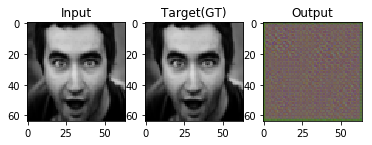

Epoch #30 | train loss: 1020.1703 | valid error: 5199.330
Epoch #31 | train loss: 1019.4943 | valid error: 5184.798
Epoch #32 | train loss: 1023.2689 | valid error: 5290.585
Epoch #33 | train loss: 1024.8788 | valid error: 5198.276
Epoch #34 | train loss: 1022.2036 | valid error: 5236.220
Epoch #35 | train loss: 1018.5780 | valid error: 5212.985
Epoch #36 | train loss: 1017.9993 | valid error: 5195.987
Epoch #37 | train loss: 1018.4788 | valid error: 5267.127
Epoch #38 | train loss: 1017.6558 | valid error: 5136.822
Epoch #39 | train loss: 1017.4663 | valid error: 5274.380


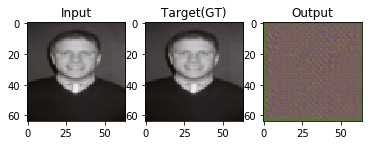

Epoch #40 | train loss: 1017.0948 | valid error: 5201.942
Epoch #41 | train loss: 1017.2368 | valid error: 5200.899
Epoch #42 | train loss: 1015.7797 | valid error: 5194.812
Epoch #43 | train loss: 1015.5607 | valid error: 5217.792
Epoch #44 | train loss: 1016.9290 | valid error: 5276.469
Epoch #45 | train loss: 1016.1058 | valid error: 5314.356
Epoch #46 | train loss: 1014.9683 | valid error: 5177.584
Epoch #47 | train loss: 1014.2827 | valid error: 5248.076
Epoch #48 | train loss: 1014.1884 | valid error: 5248.256
Epoch #49 | train loss: 1013.0096 | valid error: 5129.233


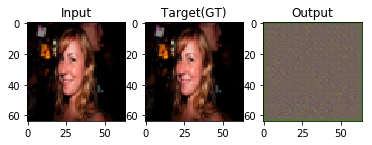

Epoch #50 | train loss: 1012.8524 | valid error: 5162.991
Epoch #51 | train loss: 1012.3173 | valid error: 5208.361
Epoch #52 | train loss: 1012.3670 | valid error: 5236.098
Epoch #53 | train loss: 1011.6909 | valid error: 5248.404
Epoch #54 | train loss: 1011.3278 | valid error: 5150.909
Epoch #55 | train loss: 1011.4533 | valid error: 5210.442
Epoch #56 | train loss: 1011.3505 | valid error: 5177.315
Epoch #57 | train loss: 1011.0538 | valid error: 5224.720
Epoch #58 | train loss: 1010.1450 | valid error: 5196.514
Epoch #59 | train loss: 1009.8602 | valid error: 5160.727


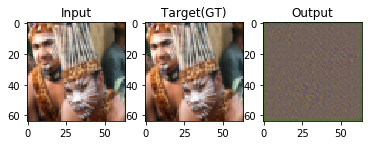

Epoch #60 | train loss: 1009.6986 | valid error: 5217.993
Epoch #61 | train loss: 1008.9636 | valid error: 5254.743
Epoch #62 | train loss: 1008.6860 | valid error: 5255.182
Epoch #63 | train loss: 1008.7008 | valid error: 5158.800
Epoch #64 | train loss: 1008.1750 | valid error: 5221.597
Epoch #65 | train loss: 1007.8197 | valid error: 5213.916
Epoch #66 | train loss: 1007.9054 | valid error: 5137.541
Epoch #67 | train loss: 1007.6235 | valid error: 5214.403
Epoch #68 | train loss: 1007.5319 | valid error: 5265.055
Epoch #69 | train loss: 1007.1365 | valid error: 5281.303


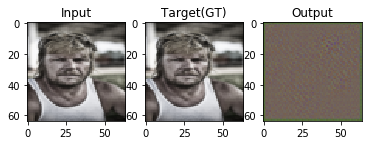

Epoch #70 | train loss: 1006.9514 | valid error: 5258.538
Epoch #71 | train loss: 1006.4118 | valid error: 5266.603
Epoch #72 | train loss: 1006.5474 | valid error: 5249.952
Epoch #73 | train loss: 1007.1906 | valid error: 5250.592
Epoch #74 | train loss: 1008.1049 | valid error: 5249.782
Epoch #75 | train loss: 1007.4322 | valid error: 5196.351
Epoch #76 | train loss: 1006.4295 | valid error: 5301.104
Epoch #77 | train loss: 1006.2121 | valid error: 5328.298
Epoch #78 | train loss: 1006.7766 | valid error: 5242.147
Epoch #79 | train loss: 1005.8871 | valid error: 5230.238


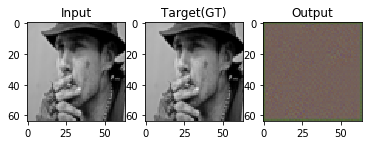

Epoch #80 | train loss: 1005.7226 | valid error: 5226.087
Epoch #81 | train loss: 1005.4413 | valid error: 5229.969
Epoch #82 | train loss: 1005.2751 | valid error: 5196.920
Epoch #83 | train loss: 1006.0834 | valid error: 5151.481
Epoch #84 | train loss: 1005.6618 | valid error: 5323.389
Epoch #85 | train loss: 1004.8307 | valid error: 5188.778
Epoch #86 | train loss: 1004.9069 | valid error: 5243.029
Epoch #87 | train loss: 1004.8255 | valid error: 5177.778
Epoch #88 | train loss: 1004.7991 | valid error: 5174.675
Epoch #89 | train loss: 1004.4888 | valid error: 5159.465


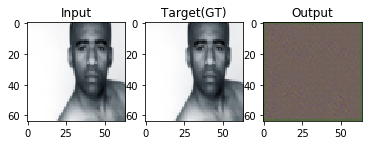

Epoch #90 | train loss: 1004.3365 | valid error: 5129.984
Epoch #91 | train loss: 1004.2769 | valid error: 5222.466
Epoch #92 | train loss: 1004.2672 | valid error: 5209.937
Epoch #93 | train loss: 1003.8981 | valid error: 5153.047
Epoch #94 | train loss: 1004.0881 | valid error: 5268.376
Epoch #95 | train loss: 1004.0325 | valid error: 5248.476
Epoch #96 | train loss: 1004.1040 | valid error: 5238.586
Epoch #97 | train loss: 1003.9357 | valid error: 5287.053
Epoch #98 | train loss: 1003.5357 | valid error: 5263.893
Epoch #99 | train loss: 1004.2841 | valid error: 5262.539


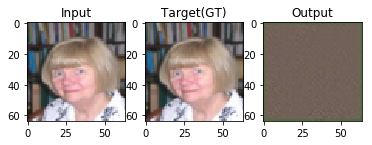

Epoch #100 | train loss: 1004.0363 | valid error: 5180.986
Epoch #101 | train loss: 1003.2490 | valid error: 5175.309
Epoch #102 | train loss: 1003.7675 | valid error: 5154.874
Epoch #103 | train loss: 1003.8150 | valid error: 5167.239
Epoch #104 | train loss: 1003.3499 | valid error: 5217.406
Epoch #105 | train loss: 1003.1105 | valid error: 5217.664
Epoch #106 | train loss: 1003.8422 | valid error: 5218.125
Epoch #107 | train loss: 1003.5331 | valid error: 5233.200
Epoch #108 | train loss: 1003.1823 | valid error: 5206.773
Epoch #109 | train loss: 1004.0112 | valid error: 5197.289


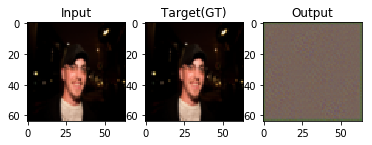

Epoch #110 | train loss: 1003.7289 | valid error: 5152.029
Epoch #111 | train loss: 1003.2271 | valid error: 5215.669
Epoch #112 | train loss: 1002.8986 | valid error: 5103.726
Epoch #113 | train loss: 1002.9875 | valid error: 5186.286
Epoch #114 | train loss: 1002.2535 | valid error: 5213.287
Epoch #115 | train loss: 1002.0971 | valid error: 5293.926
Epoch #116 | train loss: 1002.3152 | valid error: 5227.909
Epoch #117 | train loss: 1002.0580 | valid error: 5106.037
Epoch #118 | train loss: 1002.6069 | valid error: 5290.838
Epoch #119 | train loss: 1001.8704 | valid error: 5258.554


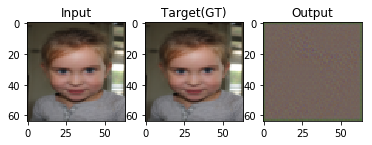

Epoch #120 | train loss: 1002.0122 | valid error: 5302.494
Epoch #121 | train loss: 1001.4601 | valid error: 5238.070
Epoch #122 | train loss: 1001.5983 | valid error: 5324.595
Epoch #123 | train loss: 1001.5197 | valid error: 5218.495
Epoch #124 | train loss: 1001.6436 | valid error: 5227.235
Epoch #125 | train loss: 1001.8554 | valid error: 5197.031
Epoch #126 | train loss: 1001.4978 | valid error: 5165.196
Epoch #127 | train loss: 1001.2957 | valid error: 5211.144
Epoch #128 | train loss: 1001.0401 | valid error: 5213.313
Epoch #129 | train loss: 1001.1197 | valid error: 5176.577


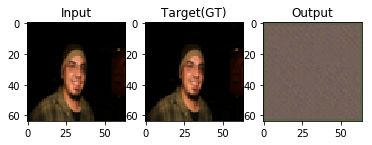

Epoch #130 | train loss: 1001.4508 | valid error: 5125.222
Epoch #131 | train loss: 1001.3614 | valid error: 5180.711
Epoch #132 | train loss: 1000.8692 | valid error: 5173.205
Epoch #133 | train loss: 1000.5049 | valid error: 5332.024
Epoch #134 | train loss: 1000.4337 | valid error: 5209.301
Epoch #135 | train loss: 1000.8619 | valid error: 5156.581
Epoch #136 | train loss: 1000.7506 | valid error: 5167.994
Epoch #137 | train loss: 1000.4210 | valid error: 5213.997
Epoch #138 | train loss: 1000.2825 | valid error: 5247.139
Epoch #139 | train loss: 1000.1812 | valid error: 5216.095


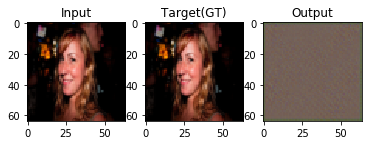

Epoch #140 | train loss: 999.8619 | valid error: 5229.228
Epoch #141 | train loss: 1000.1117 | valid error: 5191.352
Epoch #142 | train loss: 999.5548 | valid error: 5147.002
Epoch #143 | train loss: 998.8367 | valid error: 5183.265
Epoch #144 | train loss: 999.3455 | valid error: 5199.638
Epoch #145 | train loss: 999.0577 | valid error: 5184.385
Epoch #146 | train loss: 999.1527 | valid error: 5196.810
Epoch #147 | train loss: 998.3806 | valid error: 5191.655
Epoch #148 | train loss: 998.2377 | valid error: 5221.839
Epoch #149 | train loss: 997.4298 | valid error: 5254.537


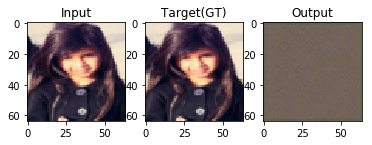

Epoch #150 | train loss: 997.1493 | valid error: 5206.088
Epoch #151 | train loss: 997.2943 | valid error: 5203.512
Epoch #152 | train loss: 995.5390 | valid error: 5158.266
Epoch #153 | train loss: 995.6812 | valid error: 5162.911
Epoch #154 | train loss: 994.3333 | valid error: 5210.031
Epoch #155 | train loss: 994.0005 | valid error: 5218.636
Epoch #156 | train loss: 993.4285 | valid error: 5149.784
Epoch #157 | train loss: 991.3881 | valid error: 5136.986
Epoch #158 | train loss: 990.0728 | valid error: 5193.921
Epoch #159 | train loss: 988.1302 | valid error: 5203.037


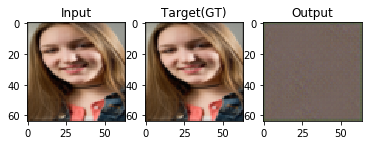

Epoch #160 | train loss: 985.7119 | valid error: 5270.366
Epoch #161 | train loss: 982.2815 | valid error: 5278.061
Epoch #162 | train loss: 978.3672 | valid error: 5316.902
Epoch #163 | train loss: 974.6901 | valid error: 5222.472
Epoch #164 | train loss: 970.2735 | valid error: 5193.322
Epoch #165 | train loss: 965.7946 | valid error: 5271.123
Epoch #166 | train loss: 957.3641 | valid error: 5276.707
Epoch #167 | train loss: 952.1978 | valid error: 5293.433
Epoch #168 | train loss: 940.9272 | valid error: 5341.952
Epoch #169 | train loss: 931.5063 | valid error: 5225.778


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


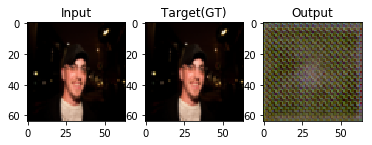

Epoch #170 | train loss: 920.9924 | valid error: 5270.670
Epoch #171 | train loss: 911.2740 | valid error: 5264.660
Epoch #172 | train loss: 898.2879 | valid error: 5389.952
Epoch #173 | train loss: 880.2071 | valid error: 5253.012
Epoch #174 | train loss: 868.2301 | valid error: 5332.070
Epoch #175 | train loss: 859.8390 | valid error: 5229.077
Epoch #176 | train loss: 838.5999 | valid error: 5321.089
Epoch #177 | train loss: 833.3346 | valid error: 5425.334
Epoch #178 | train loss: 805.1113 | valid error: 5311.154
Epoch #179 | train loss: 798.7848 | valid error: 5419.427


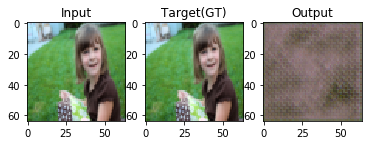

Epoch #180 | train loss: 787.3066 | valid error: 5433.106
Epoch #181 | train loss: 765.4930 | valid error: 5422.797
Epoch #182 | train loss: 739.3502 | valid error: 5386.952
Epoch #183 | train loss: 790.0655 | valid error: 5451.532
Epoch #184 | train loss: 773.9882 | valid error: 5514.171
Epoch #185 | train loss: 737.4506 | valid error: 5472.951
Epoch #186 | train loss: 715.9116 | valid error: 5529.817
Epoch #187 | train loss: 724.0597 | valid error: 5435.947
Epoch #188 | train loss: 740.9149 | valid error: 5539.612
Epoch #189 | train loss: 672.0989 | valid error: 5483.279


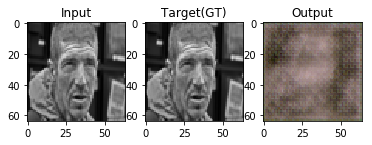

Epoch #190 | train loss: 668.7438 | valid error: 5552.553
Epoch #191 | train loss: 682.1086 | valid error: 5470.162
Epoch #192 | train loss: 680.8550 | valid error: 5607.910
Epoch #193 | train loss: 657.2735 | valid error: 5678.656
Epoch #194 | train loss: 668.1281 | valid error: 5534.917
Epoch #195 | train loss: 640.0402 | valid error: 5531.358
Epoch #196 | train loss: 647.5422 | valid error: 5599.107
Epoch #197 | train loss: 610.7406 | valid error: 5559.640
Epoch #198 | train loss: 609.5705 | valid error: 5647.296
Epoch #199 | train loss: 591.7994 | valid error: 5642.604


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


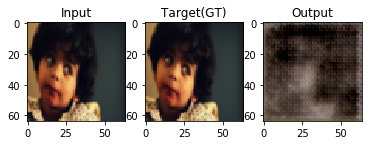

Epoch #200 | train loss: 634.7874 | valid error: 5693.514
Epoch #201 | train loss: 586.3155 | valid error: 5562.468
Epoch #202 | train loss: 636.2756 | valid error: 5600.126
Epoch #203 | train loss: 575.8196 | valid error: 5603.620
Epoch #204 | train loss: 619.2989 | valid error: 5644.857
Epoch #205 | train loss: 560.8048 | valid error: 5538.805
Epoch #206 | train loss: 621.8863 | valid error: 5659.774
Epoch #207 | train loss: 567.0176 | valid error: 5624.894
Epoch #208 | train loss: 635.1253 | valid error: 5608.941
Epoch #209 | train loss: 596.4905 | valid error: 5588.741


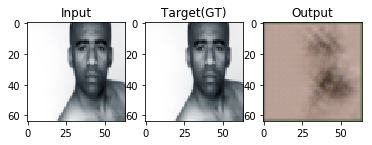

Epoch #210 | train loss: 578.0707 | valid error: 5478.905
Epoch #211 | train loss: 602.4029 | valid error: 5617.529
Epoch #212 | train loss: 545.3961 | valid error: 5571.042
Epoch #213 | train loss: 649.2271 | valid error: 5701.157
Epoch #214 | train loss: 576.8330 | valid error: 5600.681
Epoch #215 | train loss: 549.6411 | valid error: 5671.582
Epoch #216 | train loss: 542.5070 | valid error: 5573.536
Epoch #217 | train loss: 591.1516 | valid error: 5672.026
Epoch #218 | train loss: 581.0167 | valid error: 5656.281
Epoch #219 | train loss: 525.4231 | valid error: 5589.342


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


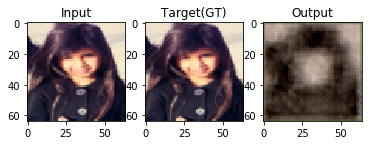

Epoch #220 | train loss: 531.5720 | valid error: 5630.880
Epoch #221 | train loss: 537.1739 | valid error: 5695.274
Epoch #222 | train loss: 512.2934 | valid error: 5649.742
Epoch #223 | train loss: 520.5954 | valid error: 5638.484
Epoch #224 | train loss: 514.1033 | valid error: 5728.700
Epoch #225 | train loss: 512.4561 | valid error: 5688.822
Epoch #226 | train loss: 511.2268 | valid error: 5751.542
Epoch #227 | train loss: 510.6974 | valid error: 5704.099
Epoch #228 | train loss: 509.3261 | valid error: 5784.038
Epoch #229 | train loss: 499.2769 | valid error: 5757.817


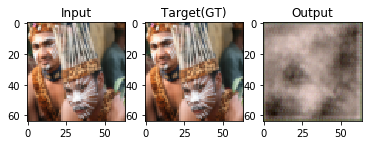

Epoch #230 | train loss: 501.0992 | valid error: 5753.999
Epoch #231 | train loss: 517.8390 | valid error: 5767.210
Epoch #232 | train loss: 497.5421 | valid error: 5765.887
Epoch #233 | train loss: 502.2684 | valid error: 5788.514
Epoch #234 | train loss: 493.3869 | valid error: 5816.539
Epoch #235 | train loss: 489.5202 | valid error: 5640.370
Epoch #236 | train loss: 499.4284 | valid error: 5676.095
Epoch #237 | train loss: 483.6643 | valid error: 5636.915
Epoch #238 | train loss: 569.6872 | valid error: 5627.700
Epoch #239 | train loss: 550.4784 | valid error: 5709.836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


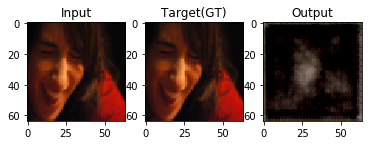

Epoch #240 | train loss: 500.1730 | valid error: 5637.630
Epoch #241 | train loss: 532.7804 | valid error: 5666.220
Epoch #242 | train loss: 502.0446 | valid error: 5638.096
Epoch #243 | train loss: 504.8575 | valid error: 5751.559
Epoch #244 | train loss: 495.2034 | valid error: 5736.323
Epoch #245 | train loss: 487.7386 | valid error: 5734.606
Epoch #246 | train loss: 497.6324 | valid error: 5674.094
Epoch #247 | train loss: 487.4304 | valid error: 5747.743
Epoch #248 | train loss: 479.4909 | valid error: 5744.467
Epoch #249 | train loss: 470.8034 | valid error: 5638.383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


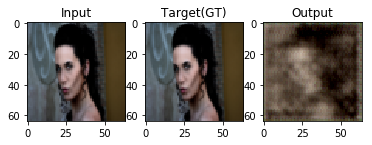

Epoch #250 | train loss: 482.0684 | valid error: 5763.057
Epoch #251 | train loss: 478.5945 | valid error: 5682.287
Epoch #252 | train loss: 494.0316 | valid error: 5781.938
Epoch #253 | train loss: 496.6103 | valid error: 5697.822
Epoch #254 | train loss: 493.5199 | valid error: 5790.484
Epoch #255 | train loss: 472.0494 | valid error: 5775.820
Epoch #256 | train loss: 469.6078 | valid error: 5671.167
Epoch #257 | train loss: 473.4218 | valid error: 5793.440
Epoch #258 | train loss: 463.9118 | valid error: 5729.163
Epoch #259 | train loss: 465.3350 | valid error: 5754.121


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


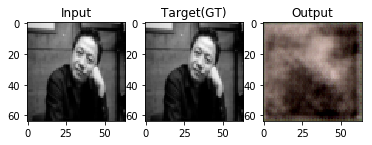

Epoch #260 | train loss: 488.0167 | valid error: 5804.846
Epoch #261 | train loss: 467.9011 | valid error: 5709.777
Epoch #262 | train loss: 456.7570 | valid error: 5751.500
Epoch #263 | train loss: 460.4790 | valid error: 5788.919
Epoch #264 | train loss: 470.0839 | valid error: 5732.127
Epoch #265 | train loss: 462.5673 | valid error: 5740.393
Epoch #266 | train loss: 453.6282 | valid error: 5761.769
Epoch #267 | train loss: 456.7181 | valid error: 5781.861
Epoch #268 | train loss: 454.8016 | valid error: 5786.817
Epoch #269 | train loss: 460.2828 | valid error: 5761.587


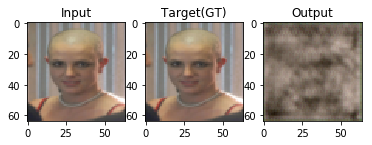

Epoch #270 | train loss: 464.7183 | valid error: 5718.400
Epoch #271 | train loss: 457.0244 | valid error: 5725.079
Epoch #272 | train loss: 465.6436 | valid error: 5807.220
Epoch #273 | train loss: 470.4951 | valid error: 5731.849
Epoch #274 | train loss: 492.1256 | valid error: 5737.398
Epoch #275 | train loss: 473.6575 | valid error: 5769.615
Epoch #276 | train loss: 470.0379 | valid error: 5727.693
Epoch #277 | train loss: 461.4631 | valid error: 5789.207
Epoch #278 | train loss: 446.0683 | valid error: 5780.222
Epoch #279 | train loss: 466.7477 | valid error: 5744.887


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


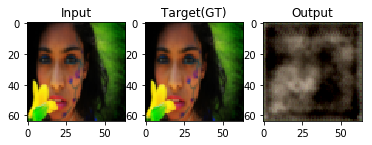

Epoch #280 | train loss: 476.8381 | valid error: 5762.555
Epoch #281 | train loss: 457.9235 | valid error: 5733.018
Epoch #282 | train loss: 459.1803 | valid error: 5767.842
Epoch #283 | train loss: 449.8376 | valid error: 5825.730
Epoch #284 | train loss: 451.4052 | valid error: 5804.403
Epoch #285 | train loss: 449.6386 | valid error: 5800.401
Epoch #286 | train loss: 482.5114 | valid error: 5713.029
Epoch #287 | train loss: 462.7579 | valid error: 5631.918
Epoch #288 | train loss: 482.0542 | valid error: 5778.165
Epoch #289 | train loss: 477.5355 | valid error: 5737.052


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


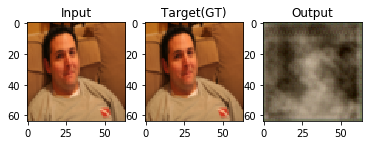

Epoch #290 | train loss: 475.7549 | valid error: 5725.805
Epoch #291 | train loss: 490.1147 | valid error: 5723.254
Epoch #292 | train loss: 500.0342 | valid error: 5577.213
Epoch #293 | train loss: 527.4211 | valid error: 5763.019
Epoch #294 | train loss: 467.7071 | valid error: 5727.057
Epoch #295 | train loss: 486.1758 | valid error: 5748.495
Epoch #296 | train loss: 446.7163 | valid error: 5690.364
Epoch #297 | train loss: 508.5555 | valid error: 5755.059
Epoch #298 | train loss: 506.9202 | valid error: 5761.579
Epoch #299 | train loss: 463.3588 | valid error: 5760.781


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


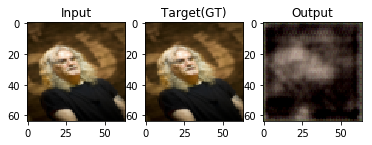

Epoch #300 | train loss: 463.3788 | valid error: 5772.292
Epoch #301 | train loss: 460.6779 | valid error: 5771.812
Epoch #302 | train loss: 459.2754 | valid error: 5802.628
Epoch #303 | train loss: 452.0647 | valid error: 5673.037
Epoch #304 | train loss: 468.2275 | valid error: 5679.267
Epoch #305 | train loss: 493.0331 | valid error: 5651.773
Epoch #306 | train loss: 541.9673 | valid error: 5706.438
Epoch #307 | train loss: 490.7187 | valid error: 5792.684
Epoch #308 | train loss: 474.4275 | valid error: 5742.522
Epoch #309 | train loss: 449.3865 | valid error: 5764.622


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


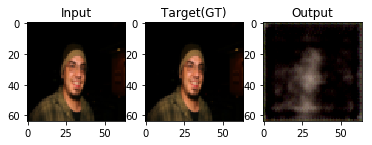

Epoch #310 | train loss: 446.1476 | valid error: 5859.781
Epoch #311 | train loss: 444.5934 | valid error: 5808.816
Epoch #312 | train loss: 465.2966 | valid error: 5731.544
Epoch #313 | train loss: 472.8574 | valid error: 5737.081
Epoch #314 | train loss: 472.0199 | valid error: 5704.472
Epoch #315 | train loss: 457.9693 | valid error: 5740.907
Epoch #316 | train loss: 461.4697 | valid error: 5714.104
Epoch #317 | train loss: 479.1841 | valid error: 5759.328
Epoch #318 | train loss: 459.2036 | valid error: 5847.765
Epoch #319 | train loss: 489.8314 | valid error: 5789.989


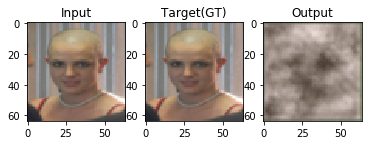

Epoch #320 | train loss: 439.7852 | valid error: 5871.860
Epoch #321 | train loss: 433.7628 | valid error: 5737.524
Epoch #322 | train loss: 433.1378 | valid error: 5801.925
Epoch #323 | train loss: 454.6613 | valid error: 5792.926
Epoch #324 | train loss: 435.7964 | valid error: 5807.841
Epoch #325 | train loss: 466.2511 | valid error: 5839.858
Epoch #326 | train loss: 434.5916 | valid error: 5740.846
Epoch #327 | train loss: 549.1892 | valid error: 5680.074
Epoch #328 | train loss: 560.4756 | valid error: 5903.865
Epoch #329 | train loss: 435.8856 | valid error: 5582.725


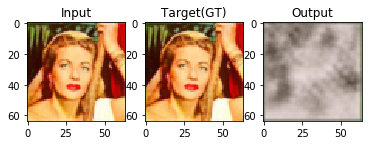

Epoch #330 | train loss: 513.1893 | valid error: 5630.495
Epoch #331 | train loss: 507.7318 | valid error: 5841.618
Epoch #332 | train loss: 428.3339 | valid error: 5728.378
Epoch #333 | train loss: 462.9333 | valid error: 5810.649
Epoch #334 | train loss: 433.7001 | valid error: 5642.242
Epoch #335 | train loss: 488.8799 | valid error: 5645.443
Epoch #336 | train loss: 479.3513 | valid error: 5825.966
Epoch #337 | train loss: 444.0181 | valid error: 5749.777
Epoch #338 | train loss: 473.0539 | valid error: 5811.263
Epoch #339 | train loss: 435.3534 | valid error: 5848.255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


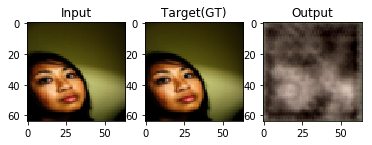

Epoch #340 | train loss: 424.5553 | valid error: 5837.066
Epoch #341 | train loss: 424.6293 | valid error: 5887.203
Epoch #342 | train loss: 429.9597 | valid error: 5813.728
Epoch #343 | train loss: 423.5219 | valid error: 5870.823
Epoch #344 | train loss: 430.1170 | valid error: 5856.354
Epoch #345 | train loss: 428.1773 | valid error: 5732.198
Epoch #346 | train loss: 432.2019 | valid error: 5767.873
Epoch #347 | train loss: 427.8338 | valid error: 5786.347
Epoch #348 | train loss: 434.2250 | valid error: 5859.033
Epoch #349 | train loss: 421.0690 | valid error: 5705.904


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


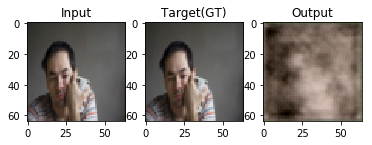

Epoch #350 | train loss: 431.1567 | valid error: 5801.804
Epoch #351 | train loss: 429.0872 | valid error: 5795.763
Epoch #352 | train loss: 422.9881 | valid error: 5856.412
Epoch #353 | train loss: 426.1673 | valid error: 5761.753
Epoch #354 | train loss: 439.3863 | valid error: 5851.817
Epoch #355 | train loss: 427.5233 | valid error: 5803.982
Epoch #356 | train loss: 423.7745 | valid error: 5839.514
Epoch #357 | train loss: 426.0330 | valid error: 5855.944
Epoch #358 | train loss: 427.3822 | valid error: 5820.302
Epoch #359 | train loss: 424.4095 | valid error: 5772.202


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


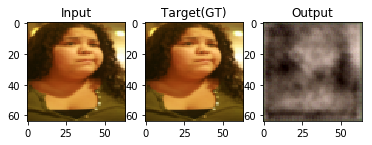

Epoch #360 | train loss: 458.8095 | valid error: 5789.735
Epoch #361 | train loss: 452.1072 | valid error: 5850.413
Epoch #362 | train loss: 426.7679 | valid error: 5847.624
Epoch #363 | train loss: 425.2837 | valid error: 5845.874
Epoch #364 | train loss: 440.3280 | valid error: 5834.943
Epoch #365 | train loss: 419.0259 | valid error: 5909.380
Epoch #366 | train loss: 422.3041 | valid error: 5824.727
Epoch #367 | train loss: 412.8597 | valid error: 5785.777
Epoch #368 | train loss: 431.4561 | valid error: 5874.579
Epoch #369 | train loss: 421.5779 | valid error: 5697.452


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


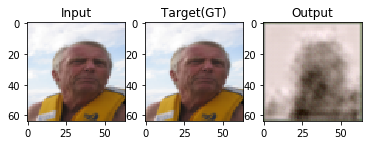

Epoch #370 | train loss: 465.7899 | valid error: 5719.731
Epoch #371 | train loss: 462.4389 | valid error: 5815.730
Epoch #372 | train loss: 432.1288 | valid error: 5895.340
Epoch #373 | train loss: 435.4702 | valid error: 5789.986
Epoch #374 | train loss: 415.4952 | valid error: 5815.382
Epoch #375 | train loss: 426.0676 | valid error: 5856.195
Epoch #376 | train loss: 429.0291 | valid error: 5807.838
Epoch #377 | train loss: 430.9208 | valid error: 5829.772
Epoch #378 | train loss: 429.0469 | valid error: 5845.675
Epoch #379 | train loss: 423.3941 | valid error: 5837.822


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


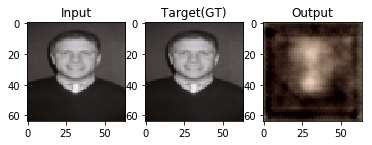

Epoch #380 | train loss: 454.5830 | valid error: 5788.475
Epoch #381 | train loss: 447.9277 | valid error: 5787.212
Epoch #382 | train loss: 426.3812 | valid error: 5841.978
Epoch #383 | train loss: 461.8052 | valid error: 5869.431
Epoch #384 | train loss: 431.5278 | valid error: 5776.791
Epoch #385 | train loss: 488.9981 | valid error: 5673.785
Epoch #386 | train loss: 546.8477 | valid error: 5878.835
Epoch #387 | train loss: 438.0444 | valid error: 5709.060
Epoch #388 | train loss: 507.3235 | valid error: 5696.867
Epoch #389 | train loss: 484.4926 | valid error: 5893.791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


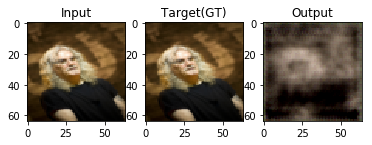

Epoch #390 | train loss: 431.3626 | valid error: 5872.726
Epoch #391 | train loss: 476.3432 | valid error: 5933.367
Epoch #392 | train loss: 421.6692 | valid error: 5743.918
Epoch #393 | train loss: 444.0534 | valid error: 5870.243
Epoch #394 | train loss: 409.7841 | valid error: 5826.659
Epoch #395 | train loss: 427.2452 | valid error: 5811.051
Epoch #396 | train loss: 416.4545 | valid error: 5714.839
Epoch #397 | train loss: 446.2929 | valid error: 5730.918
Epoch #398 | train loss: 419.3716 | valid error: 5807.309
Epoch #399 | train loss: 508.4983 | valid error: 5721.993


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


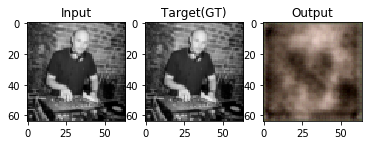

Epoch #400 | train loss: 558.2921 | valid error: 5908.832
Epoch #401 | train loss: 428.9380 | valid error: 5697.549
Epoch #402 | train loss: 467.0231 | valid error: 5752.722
Epoch #403 | train loss: 462.1450 | valid error: 5825.175
Epoch #404 | train loss: 429.4138 | valid error: 5757.842
Epoch #405 | train loss: 446.6465 | valid error: 5848.269
Epoch #406 | train loss: 420.4450 | valid error: 5782.807
Epoch #407 | train loss: 423.1271 | valid error: 5833.525
Epoch #408 | train loss: 414.4871 | valid error: 5777.127
Epoch #409 | train loss: 412.3361 | valid error: 5816.166


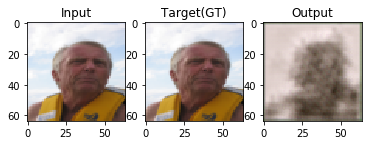

Epoch #410 | train loss: 416.9021 | valid error: 5878.959
Epoch #411 | train loss: 411.4193 | valid error: 5854.666
Epoch #412 | train loss: 420.5121 | valid error: 5818.812
Epoch #413 | train loss: 405.8054 | valid error: 5707.123
Epoch #414 | train loss: 442.0847 | valid error: 5834.580
Epoch #415 | train loss: 412.7774 | valid error: 5836.633
Epoch #416 | train loss: 416.2971 | valid error: 5860.853
Epoch #417 | train loss: 410.0712 | valid error: 5802.043
Epoch #418 | train loss: 412.0877 | valid error: 5805.885
Epoch #419 | train loss: 422.2560 | valid error: 5852.928


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


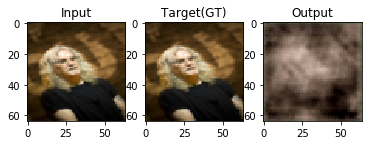

Epoch #420 | train loss: 420.6130 | valid error: 5812.716
Epoch #421 | train loss: 424.0624 | valid error: 5843.276
Epoch #422 | train loss: 433.5545 | valid error: 5823.465
Epoch #423 | train loss: 409.5546 | valid error: 5887.027
Epoch #424 | train loss: 422.5192 | valid error: 5832.024
Epoch #425 | train loss: 402.4545 | valid error: 5845.996
Epoch #426 | train loss: 410.7088 | valid error: 5873.208
Epoch #427 | train loss: 415.9043 | valid error: 5786.340
Epoch #428 | train loss: 419.7134 | valid error: 5752.122
Epoch #429 | train loss: 430.0211 | valid error: 5747.212


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


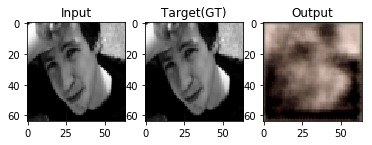

Epoch #430 | train loss: 415.7010 | valid error: 5809.398
Epoch #431 | train loss: 404.5140 | valid error: 5724.120
Epoch #432 | train loss: 427.8623 | valid error: 5760.430
Epoch #433 | train loss: 421.4265 | valid error: 5766.313
Epoch #434 | train loss: 417.2719 | valid error: 5797.767
Epoch #435 | train loss: 423.4217 | valid error: 5785.040
Epoch #436 | train loss: 421.6170 | valid error: 5795.904
Epoch #437 | train loss: 438.0317 | valid error: 5887.686
Epoch #438 | train loss: 405.8191 | valid error: 5855.345
Epoch #439 | train loss: 437.5748 | valid error: 5832.533


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


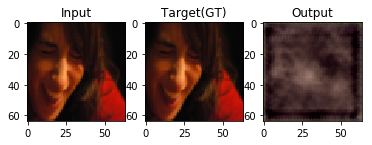

Epoch #440 | train loss: 405.6297 | valid error: 5706.937
Epoch #441 | train loss: 444.3520 | valid error: 5804.767
Epoch #442 | train loss: 421.0346 | valid error: 5797.374
Epoch #443 | train loss: 423.2257 | valid error: 5819.502
Epoch #444 | train loss: 409.2215 | valid error: 5772.876
Epoch #445 | train loss: 412.8685 | valid error: 5955.113
Epoch #446 | train loss: 403.2904 | valid error: 5859.969
Epoch #447 | train loss: 417.4384 | valid error: 5834.261
Epoch #448 | train loss: 407.1192 | valid error: 5806.806
Epoch #449 | train loss: 412.6201 | valid error: 5880.034


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


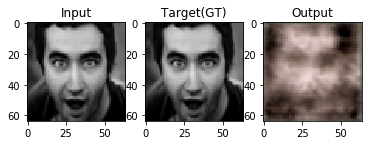

Epoch #450 | train loss: 401.0891 | valid error: 5872.472
Epoch #451 | train loss: 396.1114 | valid error: 5844.383
Epoch #452 | train loss: 406.3119 | valid error: 5836.407
Epoch #453 | train loss: 401.7686 | valid error: 5846.942
Epoch #454 | train loss: 398.7168 | valid error: 5841.666
Epoch #455 | train loss: 398.5376 | valid error: 5839.847
Epoch #456 | train loss: 428.3198 | valid error: 5874.820
Epoch #457 | train loss: 403.8235 | valid error: 5884.901
Epoch #458 | train loss: 456.7710 | valid error: 5733.207
Epoch #459 | train loss: 486.0344 | valid error: 5840.428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


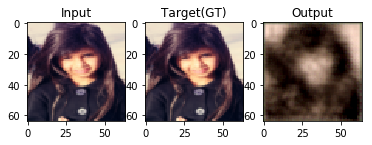

Epoch #460 | train loss: 404.0823 | valid error: 5761.942
Epoch #461 | train loss: 468.8872 | valid error: 5846.509
Epoch #462 | train loss: 439.4513 | valid error: 5903.695
Epoch #463 | train loss: 396.6034 | valid error: 5907.830
Epoch #464 | train loss: 399.8651 | valid error: 5895.449
Epoch #465 | train loss: 396.1486 | valid error: 5910.466
Epoch #466 | train loss: 407.7350 | valid error: 5889.801
Epoch #467 | train loss: 396.2260 | valid error: 5809.994
Epoch #468 | train loss: 397.6570 | valid error: 5762.658
Epoch #469 | train loss: 403.4850 | valid error: 5841.423


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


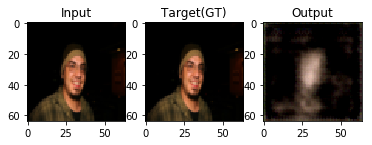

Epoch #470 | train loss: 396.0056 | valid error: 5837.988
Epoch #471 | train loss: 420.3601 | valid error: 5892.027
Epoch #472 | train loss: 399.2267 | valid error: 5827.607
Epoch #473 | train loss: 418.3531 | valid error: 5929.832
Epoch #474 | train loss: 397.8294 | valid error: 5805.078
Epoch #475 | train loss: 403.9186 | valid error: 5861.844
Epoch #476 | train loss: 391.8291 | valid error: 5824.980
Epoch #477 | train loss: 438.9986 | valid error: 5722.808
Epoch #478 | train loss: 424.4856 | valid error: 5903.815
Epoch #479 | train loss: 403.9179 | valid error: 5797.633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


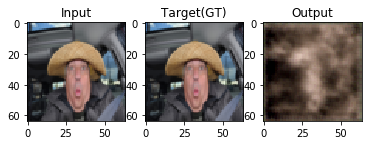

Epoch #480 | train loss: 400.6209 | valid error: 5882.283
Epoch #481 | train loss: 398.1103 | valid error: 5890.214
Epoch #482 | train loss: 394.9380 | valid error: 5842.431
Epoch #483 | train loss: 396.5746 | valid error: 5870.000
Epoch #484 | train loss: 408.3987 | valid error: 5916.729
Epoch #485 | train loss: 399.4288 | valid error: 5805.962
Epoch #486 | train loss: 440.9024 | valid error: 5820.830
Epoch #487 | train loss: 464.9461 | valid error: 5802.221
Epoch #488 | train loss: 392.6666 | valid error: 5863.245
Epoch #489 | train loss: 432.3648 | valid error: 5934.269


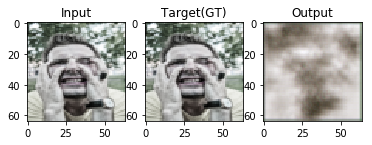

Epoch #490 | train loss: 401.3183 | valid error: 5832.378
Epoch #491 | train loss: 438.6021 | valid error: 5723.911
Epoch #492 | train loss: 481.3486 | valid error: 5858.341
Epoch #493 | train loss: 398.3414 | valid error: 5810.374
Epoch #494 | train loss: 468.4679 | valid error: 5745.245
Epoch #495 | train loss: 514.0750 | valid error: 5843.620
Epoch #496 | train loss: 401.1530 | valid error: 5597.341
Epoch #497 | train loss: 507.5194 | valid error: 5526.957
Epoch #498 | train loss: 616.6753 | valid error: 5736.502
Epoch #499 | train loss: 469.4169 | valid error: 5933.537


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


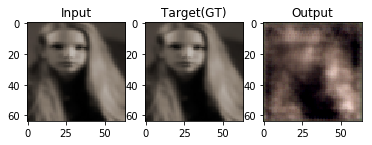

Epoch #500 | train loss: 407.4277 | valid error: 5888.582
Epoch #501 | train loss: 427.1363 | valid error: 5826.647
Epoch #502 | train loss: 403.9504 | valid error: 5858.916
Epoch #503 | train loss: 410.0842 | valid error: 5855.698
Epoch #504 | train loss: 403.8861 | valid error: 5864.847
Epoch #505 | train loss: 400.0665 | valid error: 5778.897
Epoch #506 | train loss: 402.0184 | valid error: 5842.654
Epoch #507 | train loss: 404.9754 | valid error: 5900.848
Epoch #508 | train loss: 395.8612 | valid error: 5863.952
Epoch #509 | train loss: 401.6426 | valid error: 5894.589


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


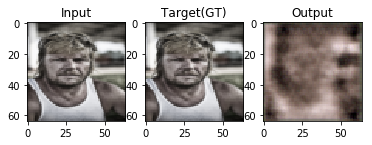

Epoch #510 | train loss: 389.3305 | valid error: 5796.464
Epoch #511 | train loss: 405.8054 | valid error: 5916.667
Epoch #512 | train loss: 394.4670 | valid error: 5868.554
Epoch #513 | train loss: 400.5062 | valid error: 5810.139
Epoch #514 | train loss: 392.7924 | valid error: 5921.092
Epoch #515 | train loss: 398.0546 | valid error: 5875.880
Epoch #516 | train loss: 396.3446 | valid error: 5853.823
Epoch #517 | train loss: 405.7843 | valid error: 5857.772
Epoch #518 | train loss: 406.3855 | valid error: 5847.152
Epoch #519 | train loss: 430.2376 | valid error: 5884.020


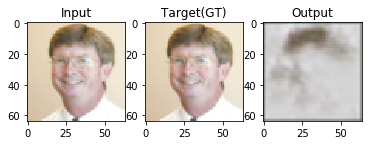

Epoch #520 | train loss: 390.8216 | valid error: 5890.695
Epoch #521 | train loss: 404.0160 | valid error: 5853.378
Epoch #522 | train loss: 391.0491 | valid error: 5821.176
Epoch #523 | train loss: 388.9091 | valid error: 5909.597
Epoch #524 | train loss: 383.7727 | valid error: 5918.971
Epoch #525 | train loss: 393.3970 | valid error: 5952.745
Epoch #526 | train loss: 390.7034 | valid error: 5875.229
Epoch #527 | train loss: 428.8633 | valid error: 5887.236
Epoch #528 | train loss: 462.1838 | valid error: 5805.553
Epoch #529 | train loss: 391.6508 | valid error: 5784.957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


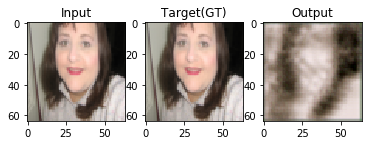

Epoch #530 | train loss: 447.5877 | valid error: 5693.839
Epoch #531 | train loss: 473.7513 | valid error: 5834.269
Epoch #532 | train loss: 407.3537 | valid error: 5800.735
Epoch #533 | train loss: 439.4856 | valid error: 5824.578
Epoch #534 | train loss: 440.3579 | valid error: 5870.373
Epoch #535 | train loss: 389.0539 | valid error: 5861.234
Epoch #536 | train loss: 411.0427 | valid error: 5909.816
Epoch #537 | train loss: 386.3238 | valid error: 5865.296
Epoch #538 | train loss: 395.0142 | valid error: 5876.538
Epoch #539 | train loss: 383.6656 | valid error: 5877.910


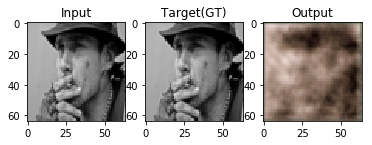

Epoch #540 | train loss: 405.5117 | valid error: 5834.319
Epoch #541 | train loss: 418.8813 | valid error: 5853.349
Epoch #542 | train loss: 398.0822 | valid error: 5783.217
Epoch #543 | train loss: 403.6569 | valid error: 5889.971
Epoch #544 | train loss: 389.5503 | valid error: 5901.492
Epoch #545 | train loss: 377.1915 | valid error: 5864.062
Epoch #546 | train loss: 409.9325 | valid error: 5926.531
Epoch #547 | train loss: 410.7877 | valid error: 5909.791
Epoch #548 | train loss: 386.3321 | valid error: 5779.228
Epoch #549 | train loss: 392.1521 | valid error: 5906.321


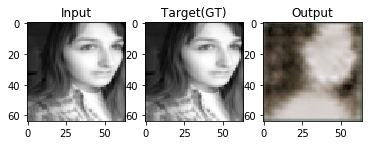

Epoch #550 | train loss: 384.0116 | valid error: 5901.687
Epoch #551 | train loss: 392.7290 | valid error: 5868.813
Epoch #552 | train loss: 382.2935 | valid error: 5957.524
Epoch #553 | train loss: 391.9352 | valid error: 5865.502
Epoch #554 | train loss: 392.2234 | valid error: 5895.622
Epoch #555 | train loss: 387.2679 | valid error: 5914.379
Epoch #556 | train loss: 388.2626 | valid error: 5906.918
Epoch #557 | train loss: 395.0697 | valid error: 5932.591
Epoch #558 | train loss: 395.5225 | valid error: 5849.340
Epoch #559 | train loss: 390.4486 | valid error: 5910.435


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


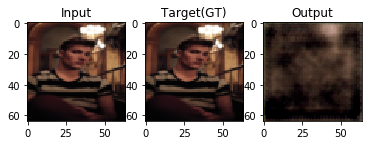

Epoch #560 | train loss: 382.9024 | valid error: 5910.381
Epoch #561 | train loss: 410.5365 | valid error: 5839.378
Epoch #562 | train loss: 382.8079 | valid error: 5755.037
Epoch #563 | train loss: 424.8980 | valid error: 5693.038
Epoch #564 | train loss: 445.6268 | valid error: 5866.758
Epoch #565 | train loss: 384.8060 | valid error: 5784.998
Epoch #566 | train loss: 418.9137 | valid error: 5822.928
Epoch #567 | train loss: 398.1460 | valid error: 5807.623
Epoch #568 | train loss: 400.3047 | valid error: 5848.860
Epoch #569 | train loss: 408.0005 | valid error: 5841.711


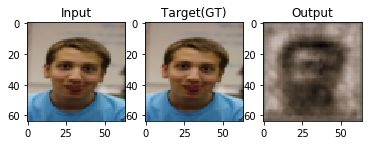

Epoch #570 | train loss: 384.3507 | valid error: 5874.075
Epoch #571 | train loss: 435.2991 | valid error: 5819.697
Epoch #572 | train loss: 411.2972 | valid error: 5797.177
Epoch #573 | train loss: 405.6444 | valid error: 5774.894
Epoch #574 | train loss: 408.2504 | valid error: 5815.086
Epoch #575 | train loss: 385.9598 | valid error: 5808.637
Epoch #576 | train loss: 398.4896 | valid error: 5886.401
Epoch #577 | train loss: 394.5651 | valid error: 5808.477
Epoch #578 | train loss: 405.3410 | valid error: 5800.469
Epoch #579 | train loss: 410.9030 | valid error: 5852.722


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


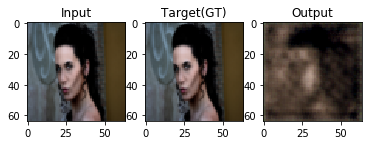

Epoch #580 | train loss: 395.7723 | valid error: 5781.688
Epoch #581 | train loss: 403.0271 | valid error: 5837.870
Epoch #582 | train loss: 389.3515 | valid error: 5812.746
Epoch #583 | train loss: 397.0603 | valid error: 5857.541
Epoch #584 | train loss: 390.5813 | valid error: 5886.965
Epoch #585 | train loss: 389.9578 | valid error: 5834.944
Epoch #586 | train loss: 405.2963 | valid error: 5835.567
Epoch #587 | train loss: 395.4486 | valid error: 5904.285
Epoch #588 | train loss: 378.6440 | valid error: 5896.411
Epoch #589 | train loss: 384.2983 | valid error: 5859.296


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


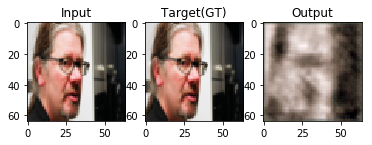

Epoch #590 | train loss: 373.3143 | valid error: 5841.260
Epoch #591 | train loss: 383.0659 | valid error: 5882.499
Epoch #592 | train loss: 382.5960 | valid error: 5836.382
Epoch #593 | train loss: 384.7071 | valid error: 5863.587
Epoch #594 | train loss: 384.7085 | valid error: 5926.669
Epoch #595 | train loss: 381.4101 | valid error: 5884.516
Epoch #596 | train loss: 383.1881 | valid error: 5875.519
Epoch #597 | train loss: 379.2442 | valid error: 5852.751
Epoch #598 | train loss: 380.4501 | valid error: 5970.757
Epoch #599 | train loss: 383.1379 | valid error: 5898.550


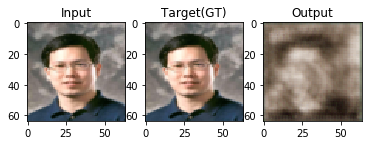

Epoch #600 | train loss: 382.6657 | valid error: 5870.456
Epoch #601 | train loss: 377.7086 | valid error: 5899.941
Epoch #602 | train loss: 375.9803 | valid error: 5850.623
Epoch #603 | train loss: 428.9474 | valid error: 5754.925
Epoch #604 | train loss: 397.1480 | valid error: 5856.886
Epoch #605 | train loss: 390.1020 | valid error: 5916.033
Epoch #606 | train loss: 400.4253 | valid error: 5931.435
Epoch #607 | train loss: 380.6503 | valid error: 5883.421
Epoch #608 | train loss: 385.1616 | valid error: 5937.895
Epoch #609 | train loss: 374.0049 | valid error: 5855.708


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


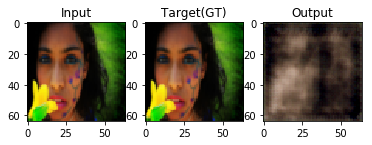

Epoch #610 | train loss: 383.9826 | valid error: 5836.216
Epoch #611 | train loss: 376.7269 | valid error: 5925.979
Epoch #612 | train loss: 369.5930 | valid error: 5925.777
Epoch #613 | train loss: 375.4077 | valid error: 5916.123
Epoch #614 | train loss: 373.9369 | valid error: 5922.452
Epoch #615 | train loss: 376.1528 | valid error: 5946.891
Epoch #616 | train loss: 387.4299 | valid error: 5875.788
Epoch #617 | train loss: 381.4198 | valid error: 5839.227
Epoch #618 | train loss: 380.6740 | valid error: 5905.741
Epoch #619 | train loss: 379.9155 | valid error: 5808.036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


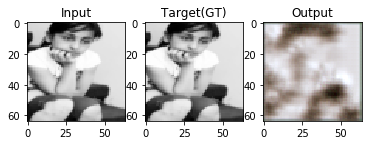

Epoch #620 | train loss: 388.4549 | valid error: 5831.894
Epoch #621 | train loss: 390.4617 | valid error: 5905.266
Epoch #622 | train loss: 374.9207 | valid error: 5907.188
Epoch #623 | train loss: 378.6745 | valid error: 5920.656
Epoch #624 | train loss: 387.8688 | valid error: 5902.862
Epoch #625 | train loss: 377.5620 | valid error: 5840.597
Epoch #626 | train loss: 411.5146 | valid error: 5888.622
Epoch #627 | train loss: 390.7401 | valid error: 5878.392
Epoch #628 | train loss: 381.0900 | valid error: 5938.215
Epoch #629 | train loss: 373.8158 | valid error: 5733.038


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


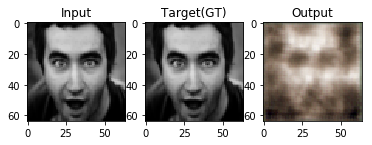

Epoch #630 | train loss: 402.6141 | valid error: 5812.156
Epoch #631 | train loss: 387.8496 | valid error: 5877.242
Epoch #632 | train loss: 386.2896 | valid error: 5876.619
Epoch #633 | train loss: 407.5084 | valid error: 5880.764
Epoch #634 | train loss: 380.0287 | valid error: 5867.671
Epoch #635 | train loss: 414.3166 | valid error: 5888.261
Epoch #636 | train loss: 404.8884 | valid error: 5840.293
Epoch #637 | train loss: 402.1615 | valid error: 5858.907
Epoch #638 | train loss: 427.5592 | valid error: 5922.796
Epoch #639 | train loss: 388.0795 | valid error: 5825.824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


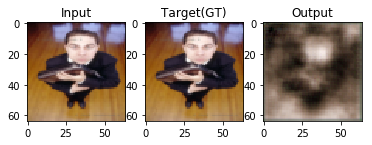

Epoch #640 | train loss: 408.7747 | valid error: 5783.221
Epoch #641 | train loss: 376.7119 | valid error: 5810.884
Epoch #642 | train loss: 403.5604 | valid error: 5888.097
Epoch #643 | train loss: 393.4103 | valid error: 5892.249
Epoch #644 | train loss: 376.8824 | valid error: 5872.695
Epoch #645 | train loss: 382.0601 | valid error: 5889.999
Epoch #646 | train loss: 371.2541 | valid error: 5807.694
Epoch #647 | train loss: 386.6715 | valid error: 5879.528
Epoch #648 | train loss: 383.9240 | valid error: 5856.720
Epoch #649 | train loss: 384.4818 | valid error: 5802.654


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


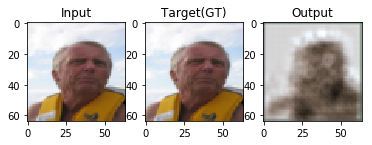

Epoch #650 | train loss: 393.7105 | valid error: 5878.105
Epoch #651 | train loss: 371.4483 | valid error: 5823.665
Epoch #652 | train loss: 385.2893 | valid error: 5927.803
Epoch #653 | train loss: 381.4041 | valid error: 5853.536
Epoch #654 | train loss: 384.1538 | valid error: 5870.380
Epoch #655 | train loss: 380.8868 | valid error: 5868.058
Epoch #656 | train loss: 373.9546 | valid error: 5878.885
Epoch #657 | train loss: 367.9788 | valid error: 5843.236
Epoch #658 | train loss: 379.7706 | valid error: 5791.682
Epoch #659 | train loss: 383.5099 | valid error: 5803.493


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


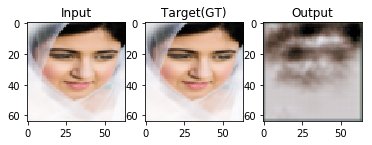

Epoch #660 | train loss: 417.5482 | valid error: 5873.104
Epoch #661 | train loss: 421.2345 | valid error: 5873.002
Epoch #662 | train loss: 377.4018 | valid error: 5794.710
Epoch #663 | train loss: 398.6703 | valid error: 5859.739
Epoch #664 | train loss: 386.0375 | valid error: 5870.154
Epoch #665 | train loss: 385.4616 | valid error: 5897.126
Epoch #666 | train loss: 370.1847 | valid error: 5804.465
Epoch #667 | train loss: 427.4344 | valid error: 5776.673
Epoch #668 | train loss: 382.2323 | valid error: 5882.743
Epoch #669 | train loss: 368.4299 | valid error: 5851.957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


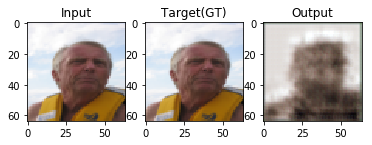

Epoch #670 | train loss: 377.2270 | valid error: 5915.864
Epoch #671 | train loss: 393.2106 | valid error: 5809.531
Epoch #672 | train loss: 400.9788 | valid error: 5873.421
Epoch #673 | train loss: 369.8174 | valid error: 5939.019
Epoch #674 | train loss: 370.6437 | valid error: 5849.452
Epoch #675 | train loss: 373.2219 | valid error: 5879.246
Epoch #676 | train loss: 370.9251 | valid error: 5855.296
Epoch #677 | train loss: 375.2788 | valid error: 5896.579
Epoch #678 | train loss: 375.6482 | valid error: 5879.147
Epoch #679 | train loss: 384.2188 | valid error: 5934.502


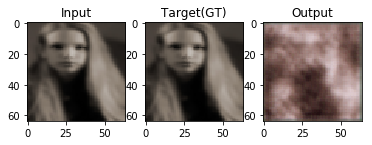

Epoch #680 | train loss: 387.1778 | valid error: 5752.840
Epoch #681 | train loss: 398.5685 | valid error: 5828.471
Epoch #682 | train loss: 420.6265 | valid error: 5906.245
Epoch #683 | train loss: 387.4054 | valid error: 5829.062
Epoch #684 | train loss: 422.2292 | valid error: 5801.892
Epoch #685 | train loss: 430.1873 | valid error: 5962.795
Epoch #686 | train loss: 375.0626 | valid error: 5733.954
Epoch #687 | train loss: 434.6089 | valid error: 5758.766
Epoch #688 | train loss: 419.0769 | valid error: 5929.513
Epoch #689 | train loss: 373.4933 | valid error: 5812.394


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


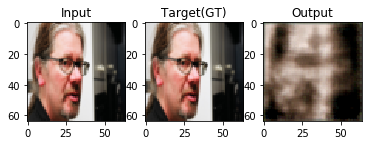

Epoch #690 | train loss: 414.9136 | valid error: 5883.762
Epoch #691 | train loss: 408.6798 | valid error: 5862.388
Epoch #692 | train loss: 381.8431 | valid error: 5817.361
Epoch #693 | train loss: 395.7506 | valid error: 5912.901
Epoch #694 | train loss: 372.1828 | valid error: 5962.667
Epoch #695 | train loss: 408.9109 | valid error: 5831.645
Epoch #696 | train loss: 401.0127 | valid error: 5819.715
Epoch #697 | train loss: 370.3299 | valid error: 5886.338
Epoch #698 | train loss: 381.3246 | valid error: 5884.607
Epoch #699 | train loss: 373.3293 | valid error: 5948.260


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


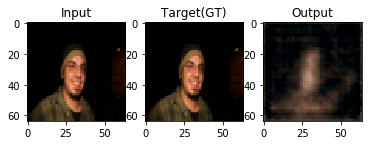

Epoch #700 | train loss: 377.9496 | valid error: 5915.951
Epoch #701 | train loss: 369.0354 | valid error: 5826.750
Epoch #702 | train loss: 386.7051 | valid error: 5950.534
Epoch #703 | train loss: 377.8799 | valid error: 6018.647
Epoch #704 | train loss: 373.0361 | valid error: 5926.649
Epoch #705 | train loss: 379.4948 | valid error: 5918.061
Epoch #706 | train loss: 370.4288 | valid error: 5874.944
Epoch #707 | train loss: 375.5446 | valid error: 5911.540
Epoch #708 | train loss: 366.4191 | valid error: 5811.322
Epoch #709 | train loss: 375.7095 | valid error: 5845.135


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


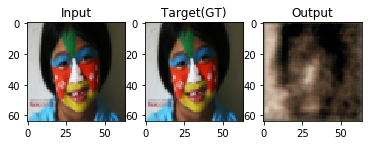

Epoch #710 | train loss: 372.8181 | valid error: 5793.491
Epoch #711 | train loss: 399.9230 | valid error: 5823.018
Epoch #712 | train loss: 421.2302 | valid error: 5836.495
Epoch #713 | train loss: 370.8249 | valid error: 5806.029
Epoch #714 | train loss: 408.3141 | valid error: 5806.614
Epoch #715 | train loss: 392.9478 | valid error: 5908.365
Epoch #716 | train loss: 371.1044 | valid error: 5897.705
Epoch #717 | train loss: 380.0598 | valid error: 5892.119
Epoch #718 | train loss: 369.1549 | valid error: 5847.935
Epoch #719 | train loss: 367.8175 | valid error: 5908.542


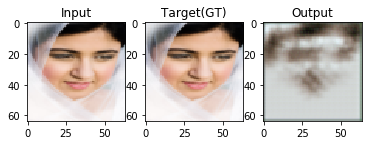

Epoch #720 | train loss: 365.9193 | valid error: 5849.540
Epoch #721 | train loss: 363.0847 | valid error: 5855.252
Epoch #722 | train loss: 377.0972 | valid error: 5886.613
Epoch #723 | train loss: 366.3932 | valid error: 5919.267
Epoch #724 | train loss: 377.8373 | valid error: 5837.130
Epoch #725 | train loss: 366.4962 | valid error: 5945.152
Epoch #726 | train loss: 378.7549 | valid error: 5929.228
Epoch #727 | train loss: 371.8913 | valid error: 5922.172
Epoch #728 | train loss: 376.9318 | valid error: 5927.867
Epoch #729 | train loss: 371.1342 | valid error: 5798.662


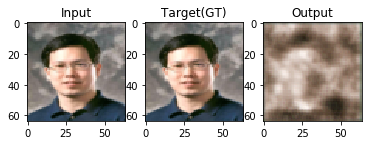

Epoch #730 | train loss: 374.3675 | valid error: 5852.614
Epoch #731 | train loss: 372.6537 | valid error: 5859.599
Epoch #732 | train loss: 376.1409 | valid error: 5879.882
Epoch #733 | train loss: 386.2925 | valid error: 5883.605
Epoch #734 | train loss: 367.8088 | valid error: 5895.092
Epoch #735 | train loss: 365.8488 | valid error: 5886.534
Epoch #736 | train loss: 369.5797 | valid error: 5901.813
Epoch #737 | train loss: 371.4610 | valid error: 5938.158
Epoch #738 | train loss: 375.0184 | valid error: 5847.465
Epoch #739 | train loss: 397.0758 | valid error: 5908.067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


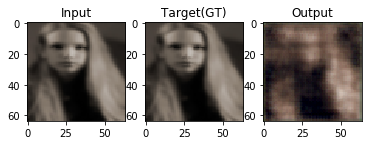

Epoch #740 | train loss: 378.6087 | valid error: 5996.524
Epoch #741 | train loss: 379.7744 | valid error: 5965.078
Epoch #742 | train loss: 379.1570 | valid error: 5952.261
Epoch #743 | train loss: 373.1532 | valid error: 5926.439
Epoch #744 | train loss: 360.2890 | valid error: 5922.750
Epoch #745 | train loss: 376.8528 | valid error: 5904.465
Epoch #746 | train loss: 373.0691 | valid error: 5876.220
Epoch #747 | train loss: 375.9043 | valid error: 5918.785
Epoch #748 | train loss: 385.4560 | valid error: 5891.602
Epoch #749 | train loss: 370.7659 | valid error: 5933.896


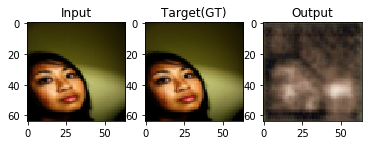

Epoch #750 | train loss: 381.1413 | valid error: 5829.142
Epoch #751 | train loss: 363.1621 | valid error: 5876.243
Epoch #752 | train loss: 370.9037 | valid error: 5856.087
Epoch #753 | train loss: 375.5110 | valid error: 5919.205
Epoch #754 | train loss: 375.2773 | valid error: 5928.554
Epoch #755 | train loss: 360.3099 | valid error: 5827.639
Epoch #756 | train loss: 362.6057 | valid error: 5914.558
Epoch #757 | train loss: 367.9589 | valid error: 5862.406
Epoch #758 | train loss: 366.6359 | valid error: 5854.921
Epoch #759 | train loss: 367.7160 | valid error: 5807.425


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


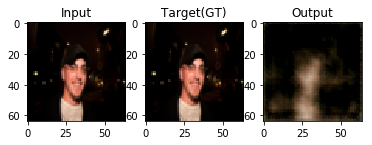

Epoch #760 | train loss: 378.7979 | valid error: 5976.263
Epoch #761 | train loss: 365.8458 | valid error: 5921.221
Epoch #762 | train loss: 387.4559 | valid error: 5901.535
Epoch #763 | train loss: 367.8330 | valid error: 5836.728
Epoch #764 | train loss: 389.6319 | valid error: 5755.630
Epoch #765 | train loss: 413.3742 | valid error: 5915.641
Epoch #766 | train loss: 370.8072 | valid error: 5893.475
Epoch #767 | train loss: 421.4561 | valid error: 5766.284
Epoch #768 | train loss: 446.7142 | valid error: 5847.991
Epoch #769 | train loss: 399.3673 | valid error: 5779.365


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


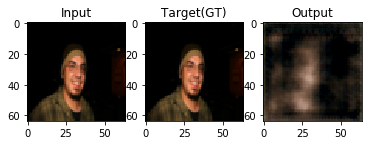

Epoch #770 | train loss: 373.6198 | valid error: 5908.420
Epoch #771 | train loss: 381.0373 | valid error: 5940.976
Epoch #772 | train loss: 380.2415 | valid error: 5912.221
Epoch #773 | train loss: 406.0047 | valid error: 5856.466
Epoch #774 | train loss: 425.0269 | valid error: 5937.821
Epoch #775 | train loss: 379.6314 | valid error: 5884.151
Epoch #776 | train loss: 387.1383 | valid error: 5806.468
Epoch #777 | train loss: 391.9788 | valid error: 5846.198
Epoch #778 | train loss: 369.2333 | valid error: 5942.471
Epoch #779 | train loss: 366.5778 | valid error: 5911.558


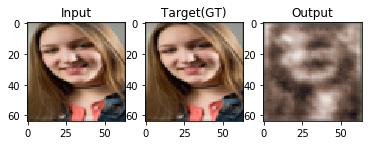

Epoch #780 | train loss: 366.1403 | valid error: 5916.999
Epoch #781 | train loss: 377.4813 | valid error: 5806.467
Epoch #782 | train loss: 366.8259 | valid error: 5963.701
Epoch #783 | train loss: 362.5843 | valid error: 5896.765
Epoch #784 | train loss: 360.7236 | valid error: 5959.279
Epoch #785 | train loss: 372.5576 | valid error: 5854.267
Epoch #786 | train loss: 381.4069 | valid error: 5907.409
Epoch #787 | train loss: 362.9778 | valid error: 5925.090
Epoch #788 | train loss: 378.1980 | valid error: 5958.999
Epoch #789 | train loss: 366.1469 | valid error: 5894.832


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


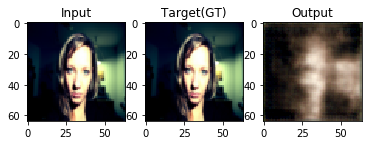

Epoch #790 | train loss: 380.8401 | valid error: 5892.449
Epoch #791 | train loss: 364.2835 | valid error: 5880.642
Epoch #792 | train loss: 369.6653 | valid error: 5917.044
Epoch #793 | train loss: 355.1413 | valid error: 5830.700
Epoch #794 | train loss: 363.4926 | valid error: 5981.259
Epoch #795 | train loss: 365.6017 | valid error: 5916.504
Epoch #796 | train loss: 363.9077 | valid error: 5865.957
Epoch #797 | train loss: 361.7211 | valid error: 5827.874
Epoch #798 | train loss: 361.1403 | valid error: 5828.100
Epoch #799 | train loss: 369.3526 | valid error: 5860.387


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


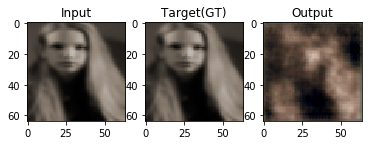

Epoch #800 | train loss: 363.5915 | valid error: 5880.705
Epoch #801 | train loss: 358.1162 | valid error: 5935.371
Epoch #802 | train loss: 372.2216 | valid error: 5909.415
Epoch #803 | train loss: 361.2674 | valid error: 5901.038
Epoch #804 | train loss: 377.5984 | valid error: 5921.667
Epoch #805 | train loss: 362.1407 | valid error: 5911.241
Epoch #806 | train loss: 363.3664 | valid error: 5815.395
Epoch #807 | train loss: 383.5192 | valid error: 5846.474
Epoch #808 | train loss: 381.4317 | valid error: 5854.752
Epoch #809 | train loss: 373.1936 | valid error: 5821.409


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


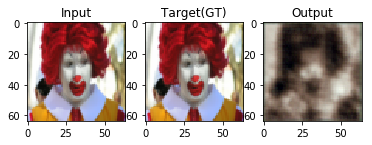

Epoch #810 | train loss: 416.6381 | valid error: 5699.875
Epoch #811 | train loss: 452.0035 | valid error: 5856.348
Epoch #812 | train loss: 385.9911 | valid error: 5877.862
Epoch #813 | train loss: 375.3810 | valid error: 5913.688
Epoch #814 | train loss: 381.6890 | valid error: 5846.051
Epoch #815 | train loss: 362.5289 | valid error: 5862.452
Epoch #816 | train loss: 371.5134 | valid error: 5922.355
Epoch #817 | train loss: 367.8792 | valid error: 5899.786
Epoch #818 | train loss: 362.6539 | valid error: 5855.391
Epoch #819 | train loss: 363.9027 | valid error: 5943.123


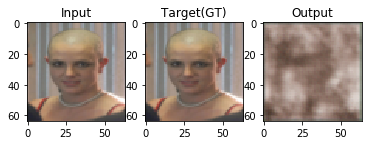

Epoch #820 | train loss: 356.7202 | valid error: 5908.904
Epoch #821 | train loss: 372.5707 | valid error: 5891.707
Epoch #822 | train loss: 388.1077 | valid error: 5886.428
Epoch #823 | train loss: 382.0287 | valid error: 5818.647
Epoch #824 | train loss: 378.4888 | valid error: 5890.685
Epoch #825 | train loss: 379.7154 | valid error: 5856.580
Epoch #826 | train loss: 394.0591 | valid error: 5935.315
Epoch #827 | train loss: 373.3760 | valid error: 5933.536
Epoch #828 | train loss: 367.6747 | valid error: 5935.559
Epoch #829 | train loss: 359.9844 | valid error: 5936.846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


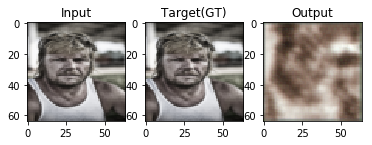

Epoch #830 | train loss: 357.1335 | valid error: 5904.103
Epoch #831 | train loss: 365.7497 | valid error: 5881.152
Epoch #832 | train loss: 362.0773 | valid error: 5873.277
Epoch #833 | train loss: 353.3083 | valid error: 5951.240
Epoch #834 | train loss: 358.5892 | valid error: 5790.605
Epoch #835 | train loss: 371.9339 | valid error: 5905.844
Epoch #836 | train loss: 368.2929 | valid error: 5899.145
Epoch #837 | train loss: 371.2194 | valid error: 5887.243
Epoch #838 | train loss: 355.9153 | valid error: 5845.120
Epoch #839 | train loss: 365.5570 | valid error: 5939.662


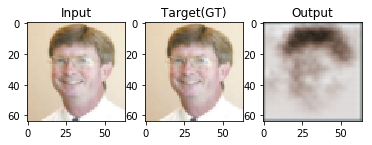

Epoch #840 | train loss: 363.0257 | valid error: 5934.220
Epoch #841 | train loss: 361.6096 | valid error: 5860.961
Epoch #842 | train loss: 377.4065 | valid error: 5854.368
Epoch #843 | train loss: 370.9363 | valid error: 5849.697
Epoch #844 | train loss: 359.1556 | valid error: 5896.487
Epoch #845 | train loss: 362.9100 | valid error: 5898.553
Epoch #846 | train loss: 355.2716 | valid error: 5862.944
Epoch #847 | train loss: 355.3578 | valid error: 5896.299
Epoch #848 | train loss: 360.8998 | valid error: 5840.165
Epoch #849 | train loss: 358.9842 | valid error: 5929.911


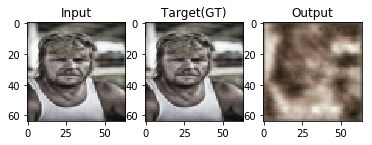

Epoch #850 | train loss: 368.6347 | valid error: 5920.549
Epoch #851 | train loss: 362.6270 | valid error: 5967.628
Epoch #852 | train loss: 355.9382 | valid error: 5944.756
Epoch #853 | train loss: 358.3299 | valid error: 5874.252
Epoch #854 | train loss: 350.9324 | valid error: 5891.633
Epoch #855 | train loss: 356.2750 | valid error: 5952.743
Epoch #856 | train loss: 355.4937 | valid error: 5886.340
Epoch #857 | train loss: 357.1160 | valid error: 5886.841
Epoch #858 | train loss: 355.3507 | valid error: 5907.310
Epoch #859 | train loss: 365.8959 | valid error: 5878.708


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


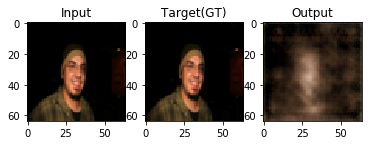

Epoch #860 | train loss: 361.6823 | valid error: 5878.514
Epoch #861 | train loss: 354.5446 | valid error: 5861.495
Epoch #862 | train loss: 359.4357 | valid error: 5865.764
Epoch #863 | train loss: 365.7192 | valid error: 5819.997
Epoch #864 | train loss: 379.5617 | valid error: 5953.852
Epoch #865 | train loss: 377.9972 | valid error: 5959.403
Epoch #866 | train loss: 364.0508 | valid error: 5891.219
Epoch #867 | train loss: 361.8660 | valid error: 5852.855
Epoch #868 | train loss: 359.6552 | valid error: 5879.023
Epoch #869 | train loss: 364.3652 | valid error: 5908.214


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


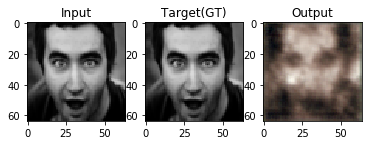

Epoch #870 | train loss: 364.9745 | valid error: 5885.072
Epoch #871 | train loss: 365.5767 | valid error: 5912.150
Epoch #872 | train loss: 366.2723 | valid error: 5895.351
Epoch #873 | train loss: 360.3981 | valid error: 5936.639
Epoch #874 | train loss: 375.1184 | valid error: 5862.337
Epoch #875 | train loss: 360.0521 | valid error: 5892.294
Epoch #876 | train loss: 374.3246 | valid error: 5867.878
Epoch #877 | train loss: 376.5242 | valid error: 5884.404
Epoch #878 | train loss: 357.7183 | valid error: 5821.485
Epoch #879 | train loss: 358.6316 | valid error: 5947.180


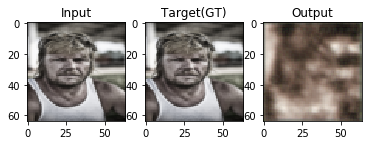

Epoch #880 | train loss: 358.4257 | valid error: 5837.390
Epoch #881 | train loss: 365.3113 | valid error: 5878.289
Epoch #882 | train loss: 366.5856 | valid error: 5915.768
Epoch #883 | train loss: 365.5080 | valid error: 5994.891
Epoch #884 | train loss: 351.5943 | valid error: 5908.897
Epoch #885 | train loss: 367.6376 | valid error: 5904.171
Epoch #886 | train loss: 352.8720 | valid error: 5979.054
Epoch #887 | train loss: 357.0564 | valid error: 5899.945
Epoch #888 | train loss: 359.0642 | valid error: 5862.424
Epoch #889 | train loss: 356.9494 | valid error: 5973.699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


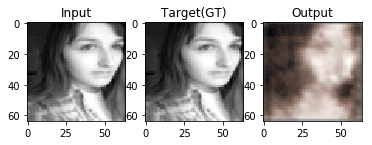

Epoch #890 | train loss: 357.5794 | valid error: 5868.878
Epoch #891 | train loss: 362.7451 | valid error: 5930.656
Epoch #892 | train loss: 358.6426 | valid error: 5952.512
Epoch #893 | train loss: 355.7936 | valid error: 5983.785
Epoch #894 | train loss: 364.6882 | valid error: 5921.504
Epoch #895 | train loss: 355.4403 | valid error: 5865.138
Epoch #896 | train loss: 355.1036 | valid error: 5905.790
Epoch #897 | train loss: 370.1257 | valid error: 5892.736
Epoch #898 | train loss: 365.3124 | valid error: 5795.897
Epoch #899 | train loss: 371.9695 | valid error: 5867.837


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


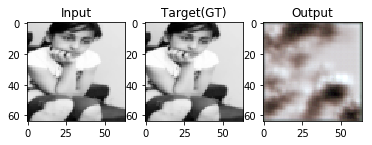

Epoch #900 | train loss: 371.5051 | valid error: 5933.848
Epoch #901 | train loss: 355.0916 | valid error: 5910.734
Epoch #902 | train loss: 367.9092 | valid error: 5836.690
Epoch #903 | train loss: 380.3315 | valid error: 5858.546
Epoch #904 | train loss: 367.4357 | valid error: 5931.747
Epoch #905 | train loss: 364.0120 | valid error: 5874.492
Epoch #906 | train loss: 378.4728 | valid error: 5931.656
Epoch #907 | train loss: 367.5541 | valid error: 5876.114
Epoch #908 | train loss: 363.9498 | valid error: 5880.340
Epoch #909 | train loss: 362.5551 | valid error: 5884.291


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


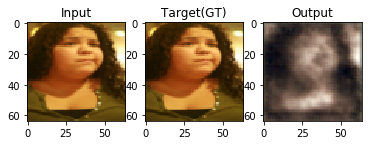

Epoch #910 | train loss: 355.2932 | valid error: 5867.761
Epoch #911 | train loss: 362.3658 | valid error: 5978.566
Epoch #912 | train loss: 355.1524 | valid error: 5904.055
Epoch #913 | train loss: 372.2445 | valid error: 5874.097
Epoch #914 | train loss: 363.0474 | valid error: 5907.380
Epoch #915 | train loss: 355.2565 | valid error: 5926.595
Epoch #916 | train loss: 354.8378 | valid error: 6011.463
Epoch #917 | train loss: 354.1720 | valid error: 5845.561
Epoch #918 | train loss: 363.3117 | valid error: 5971.455
Epoch #919 | train loss: 369.9682 | valid error: 5974.686


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


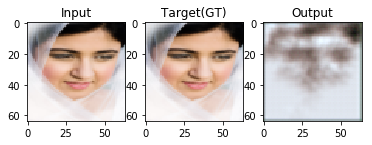

Epoch #920 | train loss: 359.0013 | valid error: 5816.108
Epoch #921 | train loss: 352.5477 | valid error: 5987.725
Epoch #922 | train loss: 352.6848 | valid error: 5907.263
Epoch #923 | train loss: 348.3744 | valid error: 5955.812
Epoch #924 | train loss: 361.1002 | valid error: 5932.500
Epoch #925 | train loss: 359.1471 | valid error: 5892.998
Epoch #926 | train loss: 351.4503 | valid error: 5990.673
Epoch #927 | train loss: 361.5083 | valid error: 5962.747
Epoch #928 | train loss: 354.3078 | valid error: 5924.369
Epoch #929 | train loss: 357.5023 | valid error: 5952.709


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


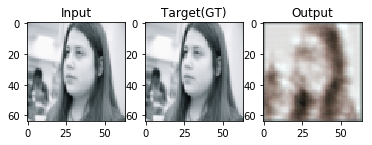

Epoch #930 | train loss: 364.8469 | valid error: 5922.513
Epoch #931 | train loss: 352.2982 | valid error: 5832.832
Epoch #932 | train loss: 353.1514 | valid error: 5951.031
Epoch #933 | train loss: 358.7796 | valid error: 5896.239
Epoch #934 | train loss: 344.9063 | valid error: 5967.055
Epoch #935 | train loss: 354.1365 | valid error: 5964.234
Epoch #936 | train loss: 359.2402 | valid error: 5953.118
Epoch #937 | train loss: 371.9704 | valid error: 5901.001
Epoch #938 | train loss: 363.6215 | valid error: 5859.674
Epoch #939 | train loss: 355.7503 | valid error: 6017.923


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


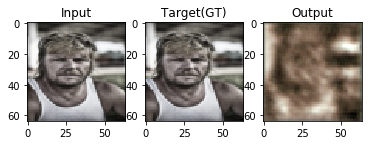

Epoch #940 | train loss: 353.4729 | valid error: 5846.375
Epoch #941 | train loss: 361.2385 | valid error: 5950.619
Epoch #942 | train loss: 353.2733 | valid error: 5994.957
Epoch #943 | train loss: 362.4621 | valid error: 5932.573
Epoch #944 | train loss: 359.8580 | valid error: 5942.633
Epoch #945 | train loss: 353.4567 | valid error: 5902.815
Epoch #946 | train loss: 356.5868 | valid error: 5985.750
Epoch #947 | train loss: 357.0713 | valid error: 5952.008
Epoch #948 | train loss: 359.0523 | valid error: 5917.133
Epoch #949 | train loss: 367.2316 | valid error: 5933.246


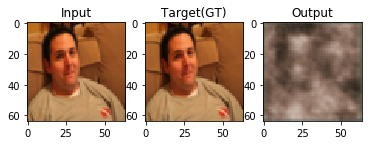

Epoch #950 | train loss: 364.1708 | valid error: 5923.746
Epoch #951 | train loss: 357.2074 | valid error: 6011.363
Epoch #952 | train loss: 354.7221 | valid error: 5929.779
Epoch #953 | train loss: 353.3672 | valid error: 5971.334
Epoch #954 | train loss: 355.2006 | valid error: 5917.290
Epoch #955 | train loss: 352.7992 | valid error: 5908.501
Epoch #956 | train loss: 354.5907 | valid error: 5973.010
Epoch #957 | train loss: 360.4131 | valid error: 5885.309
Epoch #958 | train loss: 361.5186 | valid error: 5797.115
Epoch #959 | train loss: 364.9514 | valid error: 6014.789


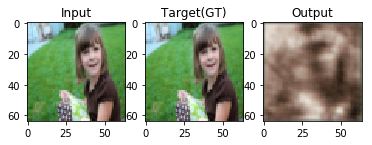

Epoch #960 | train loss: 354.2655 | valid error: 5899.085
Epoch #961 | train loss: 360.8367 | valid error: 5968.785
Epoch #962 | train loss: 361.1749 | valid error: 5916.368
Epoch #963 | train loss: 356.1566 | valid error: 5919.376
Epoch #964 | train loss: 353.0649 | valid error: 5909.768
Epoch #965 | train loss: 346.3186 | valid error: 5906.483
Epoch #966 | train loss: 351.6676 | valid error: 5983.346
Epoch #967 | train loss: 370.1859 | valid error: 6005.380
Epoch #968 | train loss: 353.8516 | valid error: 5904.752
Epoch #969 | train loss: 346.0916 | valid error: 5932.172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


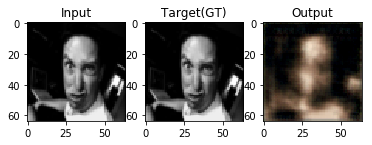

Epoch #970 | train loss: 349.7741 | valid error: 6022.366
Epoch #971 | train loss: 364.5465 | valid error: 5925.604
Epoch #972 | train loss: 357.9135 | valid error: 5942.044
Epoch #973 | train loss: 358.2141 | valid error: 5945.246
Epoch #974 | train loss: 361.7948 | valid error: 5961.735
Epoch #975 | train loss: 360.2312 | valid error: 5973.160
Epoch #976 | train loss: 349.2199 | valid error: 5871.772
Epoch #977 | train loss: 353.4045 | valid error: 5874.460
Epoch #978 | train loss: 356.4529 | valid error: 5863.247
Epoch #979 | train loss: 356.8084 | valid error: 5950.566


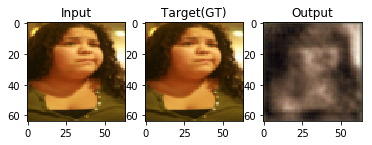

Epoch #980 | train loss: 359.3236 | valid error: 5878.992
Epoch #981 | train loss: 353.2693 | valid error: 6012.888
Epoch #982 | train loss: 345.3399 | valid error: 5916.196
Epoch #983 | train loss: 352.9304 | valid error: 5884.752
Epoch #984 | train loss: 345.3361 | valid error: 5991.420
Epoch #985 | train loss: 346.4469 | valid error: 5937.313
Epoch #986 | train loss: 350.1309 | valid error: 5924.729
Epoch #987 | train loss: 350.2994 | valid error: 5920.146
Epoch #988 | train loss: 349.7896 | valid error: 5927.791
Epoch #989 | train loss: 347.0845 | valid error: 5865.116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


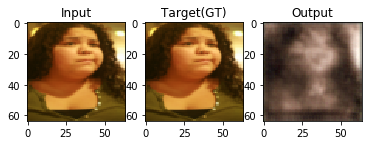

Epoch #990 | train loss: 358.4870 | valid error: 5870.625
Epoch #991 | train loss: 366.2815 | valid error: 5913.287
Epoch #992 | train loss: 357.6507 | valid error: 5943.314
Epoch #993 | train loss: 350.6431 | valid error: 5872.171
Epoch #994 | train loss: 355.9164 | valid error: 5940.609
Epoch #995 | train loss: 355.0444 | valid error: 5947.449
Epoch #996 | train loss: 356.6309 | valid error: 5932.876
Epoch #997 | train loss: 351.9054 | valid error: 5936.713
Epoch #998 | train loss: 352.6531 | valid error: 6002.456
Epoch #999 | train loss: 356.3693 | valid error: 5849.293


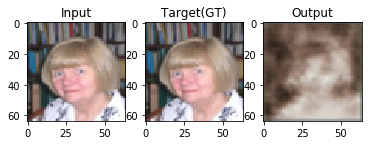

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


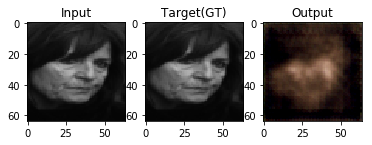

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


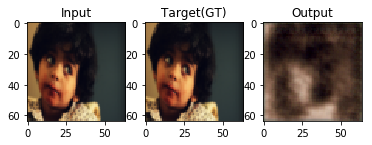

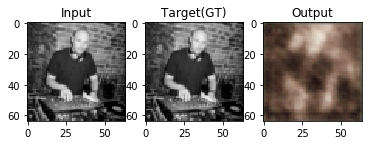

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


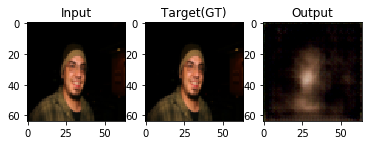

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


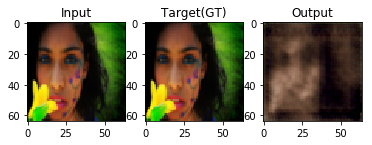

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


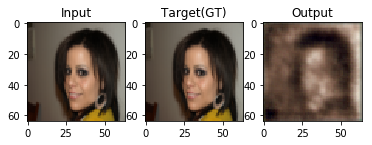

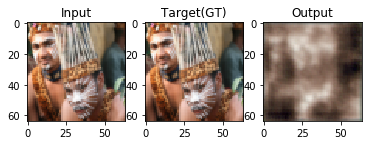

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


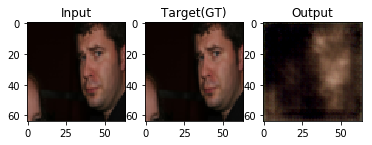

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


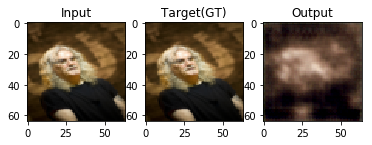

5849.292572463768

In [0]:
epoch=1000
train(model)